# Introduction

Read in data here

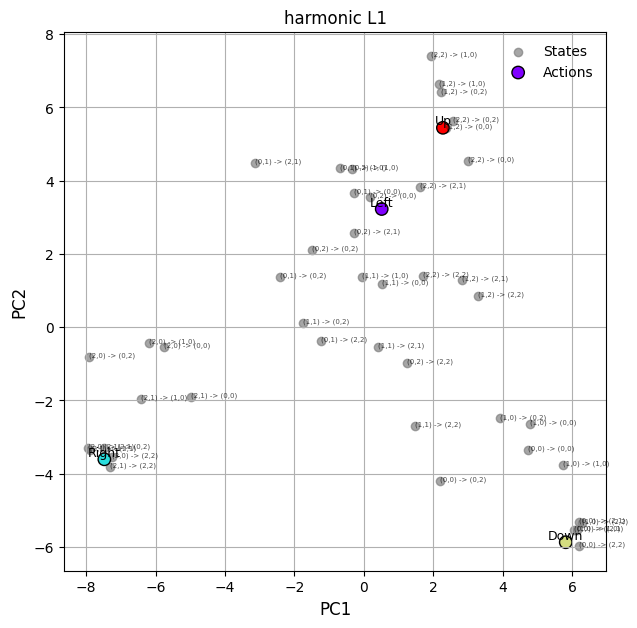

In [44]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Import necessary modules
from envs.env_mazeworld_random import MazeEnvRandom  # Adjust import based on the environment used
from utils.utils_agents import HarmonicPolicy  # Adjust based on policy
from agents.pg import PG  # Adjust based on agent type

# Define paths
save_dir = "./data/models"  # Adjust if needed
layer_type = "harmonic"  # Change if using softmax
#layer_type = "softmax"  # Change if using softmax
distance_norm = "L1"  # Adjust if different
model_path = os.path.join(save_dir, f"{layer_type}_{distance_norm}_backup.pth")

# Load environment
env = MazeEnvRandom(mode='easy', train=True)

# Load model
model = PG(env, layer_type=layer_type, distance_norm=distance_norm, n_layers=2)  # Adjust agent type
model.load_state_dict(torch.load(model_path))
model.eval()

# Extract state embeddings
H, W = env.grid_size
all_states = []
coords = []

goal_positions = env.train_goals + env.test_goals  # Iterate only over these
goal_positions = env.train_goals  # Iterate only over these


for r in range(H):
    for c in range(W):
        one_hot_agent = env._one_hot_encode((r, c))  # Encode agent position
        
        for gr, gc in goal_positions:  # Only iterate over valid goal positions
            one_hot_goal = env._one_hot_encode((gr, gc))  # Encode goal position
            full_state = np.concatenate([one_hot_agent, one_hot_goal])  # Concatenate agent + goal
            all_states.append(full_state)
            coords.append(((r, c), (gr, gc)))  # Store agent and goal positions

all_states_t = torch.tensor(all_states, dtype=torch.float32)

# Pass through model
with torch.no_grad():
    state_features = model.mlp(all_states_t)  # Feature embeddings
state_features_np = state_features.cpu().numpy()

# Extract action embeddings
if layer_type == 'harmonic':
    action_features_np = model.weights.detach().cpu().numpy()
elif layer_type == 'softmax':
    action_features_np = model.output_layer.weight.detach().cpu().numpy()
else:
    action_features_np = None

# Define action labels
action_labels = {0: "Left", 1: "Right", 2: "Down", 3: "Up"}

# Combine for PCA
if action_features_np is not None:
    combined = np.vstack([state_features_np, action_features_np])
else:
    combined = state_features_np

pca = PCA(n_components=2)
combined_2d = pca.fit_transform(combined)

n_states = state_features_np.shape[0]
states_2d = combined_2d[:n_states]
actions_2d = combined_2d[n_states:] if action_features_np is not None else None

# Plot results
plt.figure(figsize=(7,7))
plt.scatter(states_2d[:, 0], states_2d[:, 1], color='gray', alpha=0.7, label='States')

# Label states with (agent row, agent col) -> (goal row, goal col)
for i, ((ar, ac), (gr, gc)) in enumerate(coords):
    plt.text(states_2d[i, 0], states_2d[i, 1], f"({ar},{ac}) -> ({gr},{gc})", fontsize=5, alpha=0.7)

# Plot action embeddings if available
if actions_2d is not None:
    num_actions = actions_2d.shape[0]
    sc = plt.scatter(actions_2d[:, 0], actions_2d[:, 1], c=range(num_actions), cmap='rainbow', edgecolors='black', s=80, label='Actions')
    for i in range(num_actions):
        plt.text(actions_2d[i, 0], actions_2d[i, 1], action_labels.get(i, f"A{i}"), fontsize=9, ha='center', va='bottom')

plt.title(f"{layer_type} {distance_norm}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()